# atmodeller

## Silicon

Import the required functionality.

In [1]:
from atmodeller import debug_logger, debug_file_logger
from atmodeller.constraints import SystemConstraints, ElementMassConstraint, BufferedFugacityConstraint, TotalPressureConstraint, ActivityConstraint
from atmodeller.thermodata.redox_buffers import IronWustiteBuffer, IronWustiteBufferBallhaus, IronWustiteBufferFischer, IronWustiteBufferHirschmann21, IronWustiteBufferHirschmann
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet
from atmodeller.initial_solution import InitialSolutionDict 
#InitialSolution, InitialSolutionRegressor, InitialSolutionSwitchRegressor, InitialSolutionConstant
from atmodeller.core import GasSpecies, Species, LiquidSpecies
from atmodeller.solubility.hydrogen_species import H2_basalt_hirschmann, H2O_peridotite_sossi
from atmodeller.utilities import earth_oceans_to_hydrogen_mass
from atmodeller.eos.interfaces import RealGas
from atmodeller.eos.saxena import get_saxena_eos_models, H2_SS92
from atmodeller.eos.holland import get_holland_eos_models, H2_CORK_HP91, H2O_CORK_HP98
from atmodeller.eos.holley import get_holley_eos_models, H2_Beattie_holley
from atmodeller.eos.chabrier import get_chabrier_eos_models, H2_CD21

model_holland = H2_CORK_HP91
model_holley = H2_Beattie_holley
model_saxena = H2_SS92
model_chabrier = H2_CD21

eos_models: dict[str, RealGas] = get_chabrier_eos_models() # get_saxena_eos_models() # get_holley_eos_models() # get_holland_eos_models()

import logging
# logger = debug_file_logger()
logger = debug_logger()
logger.setLevel(logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## 1A. Compare H2 fugacity coefficients

In [2]:
pressures = np.logspace(0, 6, num=200)
temperature = 3400 #k


fc_holland = []
fc_holley = []
fc_saxena = []
fc_chabrier = []

for pressure in pressures:
    fc_holland.append(model_holland.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_holley.append(model_holley.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_saxena.append(model_saxena.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_chabrier.append(model_chabrier.fugacity_coefficient(temperature=temperature, pressure=pressure))

fig, ax1 = plt.subplots(1, figsize=(4,4), tight_layout='True')

ax1.plot(pressures/1e3, fc_holland, color='orange', lw=2, label=r'Holland')
ax1.plot(pressures/1e3, fc_holley, color='blue', lw=2, label=r'Holley')
ax1.plot(pressures/1e3, fc_saxena, color='red', lw=2, label=r'Saxena')
ax1.plot(pressures/1e3, fc_chabrier, color='green', lw=2, label=r'Chabrier')

ax1.set_title('H2 fugacity coefficients at %d K'%temperature)

ax1.set_ylim([0.1,1e10])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Total Pressure [kbar]', fontsize=14)
ax1.set_ylabel(r'H2 Fugacity Coefficient', fontsize=14)

# ax2.set_xlabel(r"log $f_{\rm O_2}$ ($\Delta$IW)", fontsize=14)
# ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)

# ax1a.set_ylabel(r"$P_{\rm surface}$ [kbar]", fontsize=14)
ax1.legend(ncol=1, loc='upper left')
plt.savefig('H2fugcoeff_%dK.pdf'%temperature, bbox_inches='tight')
plt.savefig('H2fugcoeff_%dK.png'%temperature, bbox_inches='tight')
plt.show()

IndexError: tuple index out of range

## 1B. Compare H2 fugacity coefficients

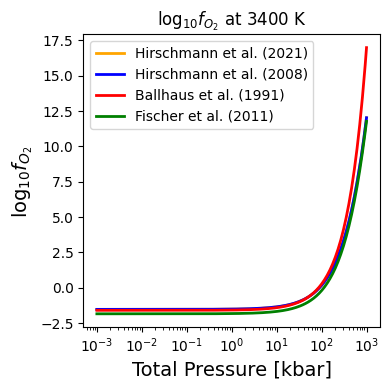

In [3]:
pressures = np.logspace(0, 6, num=200)
temperature = 3400 #k

log10fO2_hirschmann21 = np.array([IronWustiteBufferHirschmann21.get_log10_value(IronWustiteBufferHirschmann21(), temperature, pressure) for pressure in pressures])
log10fO2_hirschmann = np.array([IronWustiteBufferHirschmann.get_log10_value(IronWustiteBufferHirschmann(), temperature, pressure) for pressure in pressures])
log10fO2_ballhaus = np.array([IronWustiteBufferBallhaus.get_log10_value(IronWustiteBufferBallhaus(), temperature, pressure) for pressure in pressures])
log10fO2_fischer = np.array([IronWustiteBufferFischer.get_log10_value(IronWustiteBufferFischer(), temperature, pressure) for pressure in pressures])

fig, ax1 = plt.subplots(1, figsize=(4,4), tight_layout='True')

ax1.plot(pressures/1e3, log10fO2_hirschmann21, color='orange', lw=2, label=r'Hirschmann et al. (2021)')
ax1.plot(pressures/1e3, log10fO2_hirschmann, color='blue', lw=2, label=r'Hirschmann et al. (2008)')
ax1.plot(pressures/1e3, log10fO2_ballhaus, color='red', lw=2, label=r'Ballhaus et al. (1991)')
ax1.plot(pressures/1e3, log10fO2_fischer, color='green', lw=2, label=r'Fischer et al. (2011)')

ax1.set_title(r'log$_{10} f_{O_2}$ at %d K'%temperature)

#ax1.set_ylim([0.1,1e10])

ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlabel(r'Total Pressure [kbar]', fontsize=14)
ax1.set_ylabel(r'log$_{10} f_{O_2}$ ', fontsize=14)

# ax2.set_xlabel(r"log $f_{\rm O_2}$ ($\Delta$IW)", fontsize=14)
# ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)

# ax1a.set_ylabel(r"$P_{\rm surface}$ [kbar]", fontsize=14)
ax1.legend(ncol=1, loc='upper left')
plt.savefig('log10fO2_%dK.pdf'%temperature, bbox_inches='tight')
plt.savefig('log10fO2_%dK.png'%temperature, bbox_inches='tight')
plt.show()

## 2. Example with Element Mass Constraint for Si

In [8]:
logger: logging.Logger = debug_file_logger()

surface_temperature=3400 # kelvin
planet_mass=4.6*5.972e24 # kg
surface_radius=1.5*6371000 # metre

h_kg: float = 0.01 * planet_mass 
si_kg: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)  

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
O2Si_g = GasSpecies("O2Si")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_g, O2Si_l])

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=-4)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("Si", value=si_kg),
        ActivityConstraint(O2Si_l, 1),
    ]
)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solution = system.solve(constraints=constraint)

#print(system.output)

#print(system.output['H2O_g'][0]['melt_moles'])

ideal_solution = solution.output_solution() # system. solution.solution_dict()

logger.info("Ideal solution = %s", ideal_solution)

[13:41:58 - atmodeller.core                - INFO     ] - Creating a planet
[13:41:58 - atmodeller.core                - INFO     ] - planet_mass = 2.74712e+25
[13:41:58 - atmodeller.core                - INFO     ] - core_mass_fraction = 0.295334691460966
[13:41:58 - atmodeller.core                - INFO     ] - mantle_melt_fraction = 1.0
[13:41:58 - atmodeller.core                - INFO     ] - surface_radius = 9556500.0
[13:41:58 - atmodeller.core                - INFO     ] - surface_temperature = 3400
[13:41:58 - atmodeller.core                - INFO     ] - mantle_mass = 1.935800162393751e+25
[13:41:58 - atmodeller.core                - INFO     ] - mantle_melt_mass = 1.935800162393751e+25
[13:41:58 - atmodeller.core                - INFO     ] - mantle_solid_mass = 0.0
[13:41:58 - atmodeller.core                - INFO     ] - surface_area = 1147645061797023.5
[13:41:58 - atmodeller.core                - INFO     ] - surface_gravity = 20.076390115837132
[13:41:58 - atmodeller.int

AttributeError: 'InteriorAtmosphereSystem' object has no attribute 'solution'

## 3. H-O-Si system (ideal vs nonideal) - parameter: oxygen fugacity 

### Set basic parameters

In [ ]:
surface_temperature=3000 # kelvin
planet_mass=4.6*5.972e24 # kg
surface_radius=1.5*6371000 # metre

massH_ocean = 850 # mass of H equivalent to water oceans
h_kg: float = earth_oceans_to_hydrogen_mass(massH_ocean)

si_kg: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)  


### Calculate ideal solutions

In [ ]:
filename = "SiOH_nosolubility_ideal_3000K_800ocean.csv"
df = pd.read_csv(filename) 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
#df['H2'] = df['H2'] * adjust_sol(df['H2']) 
#df['H4Si'] = df['H4Si'] / adjust_sol(df['H2']) **2
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

log_fO2_dIWs = np.linspace(-6, 2) 

constraints = []

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg),
        ]
    )
    constraints.append(constraint)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []

i=0
for constraint, log_fO2_dIW, insol in zip(constraints, log_fO2_dIWs, insols):

    values = {H2_g: insol[0], H2O_g: insol[1], O2_g: insol[2], OSi_g: insol[3], H4Si_g: insol[4], O2Si_l: insol[5]}

    initial_solution = InitialSolutionDict(values, species=species)

    system.solve(constraint, initial_solution=initial_solution, factor=10)

    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.atmosphere_pressure
    solution['log_fO2_dIW'] = log_fO2_dIW
    try:  
        solution['melt_fraction_H'] = 2.016e-3 / h_kg * (
            system.output['H2_g'][i]['melt_moles']+system.output['H2O_g'][i]['melt_moles']
            )

        solution['fugacity_coefficient_H2'] = system.output['H2_g'][i]['fugacity_coefficient']
        solution['fugacity_coefficient_H2O'] = system.output['H2O_g'][i]['fugacity_coefficient']
        solutions.append(solution)
        i = i + 1
    except IndexError:
        i = i + 1
        continue

filename = "SiOH_nosolubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

system.failed_solves

data = system.output("SiOH_nosolubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), to_excel=True, to_pickle=False)

### Calculate ideal with solubility solutions

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.read_csv(filename) 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Non-ideal H2
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
#### Re-defining remaining species 
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

log_fO2_dIWs = np.linspace(-6, 2) 

constraints = []

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg),
        ]
    )
    constraints.append(constraint)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []
i = 0
for (log_fO2_dIW, constraint, insol) in zip(log_fO2_dIWs, constraints, insols):

    values = {H2_g: insol[0], H2O_g: insol[1], O2_g: insol[2], OSi_g: insol[3], H4Si_g: insol[4], O2Si_l: insol[5]}

    initial_solution = InitialSolutionDict(values, species=species)

    system.solve(constraint, initial_solution=initial_solution, factor=10)
    
    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.atmosphere_pressure
    solution['log_fO2_dIW'] = log_fO2_dIW
    try:  
        solution['melt_fraction_H'] = 2.016e-3 / h_kg * (
            system.output['H2_g'][i]['melt_moles']+system.output['H2O_g'][i]['melt_moles']
            )

        solution['fugacity_coefficient_H2'] = system.output['H2_g'][i]['fugacity_coefficient']
        solution['fugacity_coefficient_H2O'] = system.output['H2O_g'][i]['fugacity_coefficient']
        solutions.append(solution)
        i = i + 1
    except IndexError:
        i = i + 1
        continue


filename = "SiOH_solubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

system.failed_solves

data = system.output("SiOH_solubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), to_excel=True, to_pickle=False)

### Calculate nonideal solutions

In [ ]:
filename = "SiOH_solubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.read_csv(filename) 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Non-ideal H2
H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"])
#### Re-defining remaining species 
H2O_g = GasSpecies("H2O", eos=get_holland_eos_models()["H2O"])        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

log_fO2_dIWs = np.linspace(-6, 2) 

constraints = []

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg),
        ]
    )
    constraints.append(constraint)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []
i = 0
for (log_fO2_dIW, constraint, insol) in zip(log_fO2_dIWs, constraints, insols):

    values = {H2_g: insol[0], H2O_g: insol[1], O2_g: insol[2], OSi_g: insol[3], H4Si_g: insol[4], O2Si_l: insol[5]}

    initial_solution = InitialSolutionDict(values, species=species)

    system.solve(constraint, initial_solution=initial_solution, factor=10)
    
    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.atmosphere_pressure
    solution['log_fO2_dIW'] = log_fO2_dIW
    try:  
        solution['melt_fraction_H'] = 2.016e-3 / h_kg * (
            system.output['H2_g'][i]['melt_moles']+system.output['H2O_g'][i]['melt_moles']
            )

        solution['fugacity_coefficient_H2'] = system.output['H2_g'][i]['fugacity_coefficient']
        solution['fugacity_coefficient_H2O'] = system.output['H2O_g'][i]['fugacity_coefficient']
        solutions.append(solution)
        i = i + 1
    except IndexError:
        i = i + 1
        continue


filename = "SiOH_nosolubility_nonideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

system.failed_solves

data = system.output("SiOH_nosolubility_nonideal_%dK_%docean"%(surface_temperature,massH_ocean), to_excel=True, to_pickle=False)

### Calculate nonideal with solubility solutions

In [ ]:
filename = "SiOH_solubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.read_csv(filename) 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Non-ideal H2
H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"], solubility=H2_basalt_hirschmann())
#### Re-defining remaining species 
H2O_g = GasSpecies("H2O", eos=get_holland_eos_models()["H2O"], solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

log_fO2_dIWs = np.linspace(-6, 2) 

constraints = []

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg),
        ]
    )
    constraints.append(constraint)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []
i = 0
for (log_fO2_dIW, constraint, insol) in zip(log_fO2_dIWs, constraints, insols):

    values = {H2_g: insol[0], H2O_g: insol[1], O2_g: insol[2], OSi_g: insol[3], H4Si_g: insol[4], O2Si_l: insol[5]}

    initial_solution = InitialSolutionDict(values, species=species)

    system.solve(constraint, initial_solution=initial_solution, factor=10)
    
    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.atmosphere_pressure
    solution['log_fO2_dIW'] = log_fO2_dIW
    solution['melt_fraction_H'] = 2.016e-3 / h_kg * (
        system.output['H2_g'][i]['melt_moles']+system.output['H2O_g'][i]['melt_moles']
        )
    
    solution['fugacity_coefficient_H2'] = system.output['H2_g'][i]['fugacity_coefficient']
    solution['fugacity_coefficient_H2O'] = system.output['H2O_g'][i]['fugacity_coefficient']
    solutions.append(solution)
    i = i + 1

filename = "SiOH_solubility_nonideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

system.failed_solves

data = system.output("SiOH_solubility_nonideal_%dK_%docean"%(surface_temperature,massH_ocean), to_excel=True, to_pickle=False)

### Plot ideal vs nonideal vs nonideal with solubility

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df_ideal = pd.read_csv(filename) 
ratio_ideal = df_ideal['H2_g'].values / df_ideal['H2O_g'].values
logfO2_ideal = df_ideal['log_fO2_dIW'].values
H2_ideal = df_ideal['H2_g'].values
H2O_ideal = df_ideal['H2O_g'].values
SiH4_ideal = df_ideal['H4Si_g'].values
SiO_ideal = df_ideal['OSi_g'].values
O2_ideal = df_ideal['O2_g'].values
tot_ideal = df_ideal['total_pressure'].values
fcH2_ideal = df_ideal['fugacity_coefficient_H2'].values
fcH2O_ideal = df_ideal['fugacity_coefficient_H2O'].values
Hmelt_ideal = df_ideal['melt_fraction_H'].values

filename = "SiOH_nosolubility_nonideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df_nonideal = pd.read_csv(filename) 
ratio_nonideal = df_nonideal['H2_g'].values / df_nonideal['H2O_g'].values
logfO2_nonideal = df_nonideal['log_fO2_dIW'].values
H2_nonideal = df_nonideal['H2_g'].values
H2O_nonideal = df_nonideal['H2O_g'].values
SiH4_nonideal = df_nonideal['H4Si_g'].values
SiO_nonideal = df_nonideal['OSi_g'].values
O2_nonideal = df_nonideal['O2_g'].values
tot_nonideal = df_nonideal['total_pressure'].values
fcH2_nonideal = df_nonideal['fugacity_coefficient_H2'].values
fcH2O_nonideal = df_nonideal['fugacity_coefficient_H2O'].values
Hmelt_nonideal = df_nonideal['melt_fraction_H'].values

filename = "SiOH_solubility_nonideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df_nonidealsol = pd.read_csv(filename) 
ratio_nonidealsol = df_nonidealsol['H2_g'].values / df_nonidealsol['H2O_g'].values
logfO2_nonidealsol = df_nonidealsol['log_fO2_dIW'].values
H2_nonidealsol = df_nonidealsol['H2_g'].values
H2O_nonidealsol = df_nonidealsol['H2O_g'].values
SiH4_nonidealsol = df_nonidealsol['H4Si_g'].values
SiO_nonidealsol = df_nonidealsol['OSi_g'].values
O2_nonidealsol = df_nonidealsol['O2_g'].values
tot_nonidealsol = df_nonidealsol['total_pressure'].values
fcH2_nonidealsol = df_nonidealsol['fugacity_coefficient_H2'].values
fcH2O_nonidealsol = df_nonidealsol['fugacity_coefficient_H2O'].values
Hmelt_nonidealsol = df_nonidealsol['melt_fraction_H'].values

hmp = h_kg / planet_mass * 100

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(6,12), tight_layout='True')

#ax1.axvspan(-6, -5.8, alpha=0.2, color='red')
ax1.axvspan(-6, -2, alpha=0.2, color='green')
ax1.axvspan(-2, 2, alpha=0.2, color='blue')

ax2.axvspan(-6, -3.9, alpha=0.2, color='red')
ax2.axvspan(-3.9, -1.1, alpha=0.2, color='green')
ax2.axvspan(-1.1, 2, alpha=0.2, color='blue')

ax3.axvspan(-6, -5.1, alpha=0.2, color='red')
ax3.axvspan(-5.1, -0.4, alpha=0.2, color='green')
ax3.axvspan(-0.4, 2, alpha=0.2, color='blue')

#ax2 = ax1.twinx()

#ax1.text(-5.8, 1e-5, 'Silicon \nWorlds', fontsize=10, horizontalalignment='center')
ax1.text(-3.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
ax1.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

ax2.text(-4.8, 1e-5, 'Silicon \nWorlds', fontsize=10, horizontalalignment='center')
ax2.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
ax2.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

ax1.plot(log_fO2_dIWs, H2_ideal/tot_ideal, color='orange', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, H2O_ideal/tot_ideal, color='blue', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiH4_ideal/tot_ideal, color='red', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiO_ideal/tot_ideal, color='brown', lw=2, ls= '--')

ax1.set_title(r'Ideal + no solubility')
ax1.set_ylim([1e-6, 1.2])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)


ax2.plot(log_fO2_dIWs, H2_nonideal/tot_nonideal, color='orange', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, H2O_nonideal/tot_nonideal, color='blue', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiH4_nonideal/tot_nonideal, color='red', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiO_nonideal/tot_nonideal, color='brown', lw=2, ls= '-.')

fig.suptitle(r'Surface Atmospheric Composition (H = %.1f %% planet mass, $T_{\rm surface}$ = %d K)'%(hmp,surface_temperature)) 

ax2.set_title(r'Nonideal + no solubility') 
ax2.set_ylim([1e-6, 1.2])
ax2.set_yscale('log')
ax2.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax2.set_ylabel(r'Mixing Ratios', fontsize=14)

ax3.plot(log_fO2_dIWs, H2_nonidealsol/tot_nonidealsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_nonidealsol/tot_nonidealsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_nonidealsol/tot_nonidealsol, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_nonidealsol/tot_nonidealsol, color='brown', lw=2, ls= '-', label='SiO')

ax3.set_title(r'Nonideal + solubility') 
ax3.set_ylim([1e-6, 1.2])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Mixing Ratios', fontsize=14)

ax4.plot(log_fO2_dIWs, tot_ideal/1000, lw=2, ls= '--', color='black', label=r'Ideal (no solubility)')
ax4.plot(log_fO2_dIWs, tot_nonideal/1000, lw=2, ls= '-.', color='black', label=r'Nonideal (no solubility)')
ax4.plot(log_fO2_dIWs, tot_nonidealsol/1000, lw=2, ls= '-', color='black', label=r'Nonideal (solubility)')

ax4.set_ylim([1e0, 1e3])
ax4.set_yscale('log')
ax4.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax4.set_ylabel(r"$P_{\rm surface}$ [kbar]",  fontsize=14)

ax4.set_title(r'Surface Pressure')

ax3.legend(ncol=2, loc='lower left')
ax4.legend(ncol=1, loc='lower left')

plt.savefig("SiOH_ideal_nonideal_nonidealsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_ideal_nonideal_nonidealsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Plot ideal vs ideal with solubility vs nonideal with solubility

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df_ideal = pd.read_csv(filename) 
ratio_ideal = df_ideal['H2_g'].values / df_ideal['H2O_g'].values
logfO2_ideal = df_ideal['log_fO2_dIW'].values
H2_ideal = df_ideal['H2_g'].values
H2O_ideal = df_ideal['H2O_g'].values
SiH4_ideal = df_ideal['H4Si_g'].values
SiO_ideal = df_ideal['OSi_g'].values
O2_ideal = df_ideal['O2_g'].values
tot_ideal = df_ideal['total_pressure'].values
fcH2_ideal = df_ideal['fugacity_coefficient_H2'].values
fcH2O_ideal = df_ideal['fugacity_coefficient_H2O'].values
Hmelt_ideal = df_ideal['melt_fraction_H'].values

filename = "SiOH_solubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df_idealsol = pd.read_csv(filename) 
ratio_idealsol = df_idealsol['H2_g'].values / df_idealsol['H2O_g'].values
logfO2_idealsol = df_idealsol['log_fO2_dIW'].values
H2_idealsol = df_idealsol['H2_g'].values
H2O_idealsol = df_idealsol['H2O_g'].values
SiH4_idealsol = df_idealsol['H4Si_g'].values
SiO_idealsol = df_idealsol['OSi_g'].values
O2_idealsol = df_idealsol['O2_g'].values
tot_idealsol = df_idealsol['total_pressure'].values
fcH2_idealsol = df_idealsol['fugacity_coefficient_H2'].values
fcH2O_idealsol = df_idealsol['fugacity_coefficient_H2O'].values
Hmelt_idealsol = df_idealsol['melt_fraction_H'].values

filename = "SiOH_solubility_nonideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df_nonidealsol = pd.read_csv(filename) 
ratio_nonidealsol = df_nonidealsol['H2_g'].values / df_nonidealsol['H2O_g'].values
logfO2_nonidealsol = df_nonidealsol['log_fO2_dIW'].values
H2_nonidealsol = df_nonidealsol['H2_g'].values
H2O_nonidealsol = df_nonidealsol['H2O_g'].values
SiH4_nonidealsol = df_nonidealsol['H4Si_g'].values
SiO_nonidealsol = df_nonidealsol['OSi_g'].values
O2_nonidealsol = df_nonidealsol['O2_g'].values
tot_nonidealsol = df_nonidealsol['total_pressure'].values
fcH2_nonidealsol = df_nonidealsol['fugacity_coefficient_H2'].values
fcH2O_nonidealsol = df_nonidealsol['fugacity_coefficient_H2O'].values
Hmelt_nonidealsol = df_nonidealsol['melt_fraction_H'].values

hmp = h_kg / planet_mass * 100

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(6,12), tight_layout='True')

#ax1.axvspan(-6, -5.8, alpha=0.2, color='red')
ax1.axvspan(-6, -1.8, alpha=0.2, color='green')
ax1.axvspan(-1.8, 2, alpha=0.2, color='blue')

ax2.axvspan(-6, -5.6, alpha=0.2, color='red')
ax2.axvspan(-5.6, -0.2, alpha=0.2, color='green')
ax2.axvspan(-0.2, 2, alpha=0.2, color='blue')

ax3.axvspan(-6, -4.3, alpha=0.2, color='red')
ax3.axvspan(-4.3, -0.6, alpha=0.2, color='green')
ax3.axvspan(-0.6, 2, alpha=0.2, color='blue')

#ax2 = ax1.twinx()

#ax1.text(-5.8, 1e-5, 'Silicon \nWorlds', fontsize=10, horizontalalignment='center')
ax1.text(-3.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
ax1.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

ax2.text(-5.8, 1e-5, 'Silicon \nWorlds', fontsize=10, horizontalalignment='center')
ax2.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
ax2.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

ax1.plot(log_fO2_dIWs, H2_ideal/tot_ideal, color='orange', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, H2O_ideal/tot_ideal, color='blue', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiH4_ideal/tot_ideal, color='red', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiO_ideal/tot_ideal, color='brown', lw=2, ls= '--')

ax1.set_title(r'Ideal + no solubility')
ax1.set_ylim([1e-6, 1.2])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)


ax2.plot(log_fO2_dIWs, H2_idealsol/tot_idealsol, color='orange', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, H2O_idealsol/tot_idealsol, color='blue', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiH4_idealsol/tot_idealsol, color='red', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiO_idealsol/tot_idealsol, color='brown', lw=2, ls= '-.')

fig.suptitle(r'Surface Atm. Comp. (H = %.1f %% planet mass, $T_{\rm surface}$ = %d K)'%(hmp,surface_temperature)) 

ax2.set_title(r'Ideal + solubility') 
ax2.set_ylim([1e-6, 1.2])
ax2.set_yscale('log')
ax2.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax2.set_ylabel(r'Mixing Ratios', fontsize=14)

ax3.plot(log_fO2_dIWs, H2_nonidealsol/tot_nonidealsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_nonidealsol/tot_nonidealsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_nonidealsol/tot_nonidealsol, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_nonidealsol/tot_nonidealsol, color='brown', lw=2, ls= '-', label='SiO')

ax3.set_title(r'Real + solubility') 
ax3.set_ylim([1e-6, 1.2])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Mixing Ratios', fontsize=14)

ax4.plot(log_fO2_dIWs, tot_ideal/1000, lw=2, ls= '--', color='black', label=r'Ideal gas (no solubility)')
ax4.plot(log_fO2_dIWs, tot_idealsol/1000, lw=2, ls= '-.', color='black', label=r'Ideal gas (solubility)')
ax4.plot(log_fO2_dIWs, tot_nonidealsol/1000, lw=2, ls= '-', color='black', label=r'Real gas (solubility)')

ax4.set_ylim([1e0, 3e2])
ax4.set_yscale('log')
ax4.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax4.set_ylabel(r"$P_{\rm surface}$ [kbar]",  fontsize=14)

ax4.set_title(r'Surface Pressure')

ax3.legend(ncol=2, loc='lower left')
ax4.legend(ncol=1, loc='lower left')

plt.savefig("SiOH_ideal_idealsol_nonidealsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_ideal_idealsol_nonidealsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(log_fO2_dIWs, fcH2_ideal, color='orange', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, fcH2O_ideal, color='blue', lw=2, ls= '--')
# ax1.plot(log_fO2_dIWs, fcH2_nonideal, color='orange', lw=2, ls= '-.')
# ax1.plot(log_fO2_dIWs, fcH2O_nonideal, color='blue', lw=2, ls= '-.')
l1, = ax1.plot(log_fO2_dIWs, fcH2_nonidealsol, color='orange', lw=2, ls= '-', label='H$_2$')
l2, = ax1.plot(log_fO2_dIWs, fcH2O_nonidealsol, color='blue', lw=2, ls= '-', label='H$_2$O')

ax1.set_title(r'Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([8e-1, 2e2])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficients', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='--', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles=custom_handles + old_handles, ncol=2, loc='upper right')

plt.savefig("fugacitycoeff_SiOH_nonideal_nonidealsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOH_nonideal_nonidealsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### H partitioning

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(log_fO2_dIWs, 100 * Hmelt_ideal, color='black', lw=2, ls= '--',  label='Ideal gas (no solubility)')
ax1.plot(log_fO2_dIWs, 100 * Hmelt_idealsol, color='black', lw=2, ls= '-.', label='Ideal gas (solubility)')
ax1.plot(log_fO2_dIWs, 100 * Hmelt_nonidealsol, color='black', lw=2, ls= '-', label='Real gas (solubility)')

ax1.set_title(r'Hydrogen Partitioning in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

#ax1.set_ylim([8e-1, 3e1])
#ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'H fraction in magma [%]', fontsize=12)

ax1.legend(ncol=1, loc='lower right')

plt.savefig("Hmelt_SiOH_nonideal_nonidealsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("Hmelt_SiOH_nonideal_nonidealsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

## 4. H-O-Si system (ideal vs nonideal) - parameter: amount of H 

### Set basic parameters

In [ ]:
surface_temperature=3000 # kelvin
planet_mass=4.6*5.972e24 # kg
surface_radius=1.5*6371000 # metre

log_fO2_dIW = -4

si_kg: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)  

massH_oceans = np.linspace(1, 3000)

### Calculate ideal solutions

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])



constraints = []

for massH_ocean in massH_oceans:

    h_kg: float = earth_oceans_to_hydrogen_mass(massH_ocean)   

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            #TotalPressureConstraint(value=total_pressure),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg),
        ]
    )
    constraints.append(constraint)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []

i=0
for constraint in constraints:

    system.solve(constraint)
    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.atmosphere_pressure
    solution['log_fO2_dIW'] = log_fO2_dIW
    try:  
        solution['melt_fraction_H'] = 2.016e-3 / h_kg * (
            system.output['H2_g'][i]['melt_moles']+system.output['H2O_g'][i]['melt_moles']
            )

        solution['fugacity_coefficient_H2'] = 1
        solution['fugacity_coefficient_H2O'] = 1
        solutions.append(solution)
        i = i + 1
    except IndexError:
        i = i + 1
        continue

filename = "SiOH_nosolubility_ideal_%dK_IW%dlogfO2.csv"%(surface_temperature,log_fO2_dIW)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

system.failed_solves

data = system.output("SiOH_nosolubility_ideal_%dK_IW%dlogfO2"%(surface_temperature,log_fO2_dIW), to_excel=True, to_pickle=False)

### Calculate nonideal solutions

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_IW%dlogfO2.csv"%(surface_temperature,log_fO2_dIW)
df = pd.read_csv(filename) 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Non-ideal H2
H2_g = GasSpecies("H2", eos=eos_models["H2"])
#### Re-defining remaining species 
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

constraints = []

for massH_ocean in massH_oceans:

    h_kg: float = earth_oceans_to_hydrogen_mass(massH_ocean)   

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            #TotalPressureConstraint(value=total_pressure),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg),
        ]
    )
    constraints.append(constraint)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []

i=0
for (massH_ocean, constraint, insol) in zip(massH_oceans, constraints, insols):

    values = {H2_g: insol[0], H2O_g: insol[1], O2_g: insol[2], OSi_g: insol[3], H4Si_g: insol[4], O2Si_l: insol[5]}

    initial_solution = InitialSolutionDict(values, species=species)

    system.solve(constraint, initial_solution=initial_solution, factor=10)
    
    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.atmosphere_pressure
    solution['log_fO2_dIW'] = log_fO2_dIW
    try:  
        solution['melt_fraction_H'] = 2.016e-3 / h_kg * (
            system.output['H2_g'][i]['melt_moles']+system.output['H2O_g'][i]['melt_moles']
            )

        solution['fugacity_coefficient_H2'] = system.output['H2_g'][i]['fugacity_coefficient']
        solution['fugacity_coefficient_H2O'] = system.output['H2O_g'][i]['fugacity_coefficient']
        solutions.append(solution)
        i = i + 1
    except IndexError:
        i = i + 1
        continue

filename = "SiOH_nosolubility_nonideal_%dK_IW%dlogfO2.csv"%(surface_temperature,log_fO2_dIW)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

system.failed_solves

data = system.output("SiOH_nosolubility_nonideal_%dK_IW%dlogfO2"%(surface_temperature,log_fO2_dIW), to_excel=True, to_pickle=False)

### Plot ideal vs nonideal

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_IW%dlogfO2.csv"%(surface_temperature,log_fO2_dIW)
df_ideal = pd.read_csv(filename) 
ratio_ideal = df_ideal['H2_g'].values / df_ideal['H2O_g'].values
logfO2_ideal = df_ideal['log_fO2_dIW'].values
H2_ideal = df_ideal['H2_g'].values
H2O_ideal = df_ideal['H2O_g'].values
SiH4_ideal = df_ideal['H4Si_g'].values
SiO_ideal = df_ideal['OSi_g'].values
O2_ideal = df_ideal['O2_g'].values
tot_ideal = df_ideal['total_pressure'].values
fcH2_ideal = df_ideal['fugacity_coefficient_H2'].values
fcH2O_ideal = df_ideal['fugacity_coefficient_H2O'].values
Hmelt_ideal = df_ideal['melt_fraction_H'].values

# filename = "SiOH_solubility_ideal_%dK__IW%dlogfO2.csv"%(surface_temperature,log_fO2_dIW)
# df_idealsol = pd.read_csv(filename) 
# ratio_idealsol = df_idealsol['H2_g'].values / df_idealsol['H2O_g'].values
# logfO2_idealsol = df_idealsol['log_fO2_dIW'].values
# H2_idealsol = df_idealsol['H2_g'].values
# H2O_idealsol = df_idealsol['H2O_g'].values
# SiH4_idealsol = df_idealsol['H4Si_g'].values
# SiO_idealsol = df_idealsol['OSi_g'].values
# O2_idealsol = df_idealsol['O2_g'].values
# tot_idealsol = df_idealsol['total_pressure'].values
# fcH2_idealsol = df_idealsol['fugacity_coefficient_H2'].values
# fcH2O_idealsol = df_idealsol['fugacity_coefficient_H2O'].values
# Hmelt_idealsol = df_idealsol['melt_fraction_H'].values

filename = "SiOH_nosolubility_nonideal_%dK_IW%dlogfO2.csv"%(surface_temperature,log_fO2_dIW)
df_nonideal = pd.read_csv(filename) 
ratio_nonideal = df_nonideal['H2_g'].values / df_nonideal['H2O_g'].values
logfO2_nonideal = df_nonideal['log_fO2_dIW'].values
H2_nonideal = df_nonideal['H2_g'].values
H2O_nonideal = df_nonideal['H2O_g'].values
SiH4_nonideal = df_nonideal['H4Si_g'].values
SiO_nonideal = df_nonideal['OSi_g'].values
O2_nonideal = df_nonideal['O2_g'].values
tot_nonideal = df_nonideal['total_pressure'].values
fcH2_nonideal = df_nonideal['fugacity_coefficient_H2'].values
fcH2O_nonideal = df_nonideal['fugacity_coefficient_H2O'].values
Hmelt_nonideal = df_nonideal['melt_fraction_H'].values

h_kgs = earth_oceans_to_hydrogen_mass(massH_oceans)
hmf = h_kgs / planet_mass * 100

fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

# ax1.set_ylim([1e-10,1.2])
# ax1.axvspan(2.6e-2, 1e0, alpha=0.2, color='blue')
# ax1.axvspan(1e0, 2e2, alpha=0.2, color='green')
# ax1.axvspan(2e2, 3e3, alpha=0.2, color='red')

ax2 = ax1.twinx()

ax2.plot(hmf, tot_ideal/1000, color='gray', lw=2, ls= '--', label=r'Ideal', zorder=0)

ax2.plot(hmf, tot_nonideal/1000, color='gray', lw=2, label=r'Real', zorder=0)

# ax1.text(3e-2, 1e-3, 'Steam Worlds', fontsize=10)
# ax1.text(3, 1e-5, 'Hydrogen Worlds', fontsize=10)
# ax1.text(2e2, 1e-7, 'Silicon Worlds', fontsize=10)

ax1.plot(hmf, H2_ideal/tot_ideal, color='orange', lw=2, ls= '--')
ax1.plot(hmf, H2O_ideal/tot_ideal, color='blue', lw=2, ls= '--')
ax1.plot(hmf, SiH4_ideal/tot_ideal, color='red', lw=2, ls= '--')
ax1.plot(hmf, SiO_ideal/tot_ideal, color='brown', lw=2, ls= '--')

ax1.plot(hmf, H2_nonideal/tot_nonideal, color='orange', lw=2, label=r'H$_2$')
ax1.plot(hmf, H2O_nonideal/tot_nonideal, color='blue', lw=2, label=r'H$_2$O')
ax1.plot(hmf, SiH4_nonideal/tot_nonideal, color='red', lw=2, label=r'SiH$_4$')
ax1.plot(hmf, SiO_nonideal/tot_nonideal, color='brown', lw=2, label=r'SiO')

ax1.set_title('Atmospheric Composition at the Surface at %d K'%surface_temperature)

#ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)

ax2.set_yscale('log')
ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", color='gray', fontsize=14)

ax1.legend(ncol=2, loc='lower left')
ax2.legend(ncol=1, loc=(0.02, 0.2))

plt.savefig("SiOH_nosolubility_ideal_nonideal_%dK_IW%dlogfO2.pdf"%(surface_temperature,log_fO2_dIW), bbox_inches='tight')
plt.savefig("SiOH_nosolubility_ideal_nonideal_%dK_IW%dlogfO2.png"%(surface_temperature,log_fO2_dIW), bbox_inches='tight')
plt.show()

### Calculate nonideal with solubility solutions

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_IW%dlogfO2.csv"%(surface_temperature,log_fO2_dIW)
df = pd.read_csv(filename) 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Non-ideal H2
H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"], solubility=H2_basalt_hirschmann())
#### Re-defining remaining species 
H2O_g = GasSpecies("H2O", eos=get_holland_eos_models()["H2O"], solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

constraints = []

for massH_ocean in massH_oceans:

    h_kg: float = earth_oceans_to_hydrogen_mass(massH_ocean)   

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            #TotalPressureConstraint(value=total_pressure),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg),
        ]
    )
    constraints.append(constraint)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []

for (massH_ocean, constraint, insol) in zip(massH_oceans, constraints, insols):

    values = {H2_g: insol[0], H2O_g: insol[1], O2_g: insol[2], OSi_g: insol[3], H4Si_g: insol[4], O2Si_l: insol[5]}

    initial_solution = InitialSolutionDict(values, species=species)

    system.solve(constraint, initial_solution=initial_solution, factor=10)
    
    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.atmosphere_pressure
    solution['log_fO2_dIW'] = log_fO2_dIW
    try:  
        solution['melt_fraction_H'] = 2.016e-3 / h_kg * (
            system.output['H2_g'][i]['melt_moles']+system.output['H2O_g'][i]['melt_moles']
            )

        solution['fugacity_coefficient_H2'] = system.output['H2_g'][i]['fugacity_coefficient']
        solution['fugacity_coefficient_H2O'] = system.output['H2O_g'][i]['fugacity_coefficient']
        solutions.append(solution)
        i = i + 1
    except IndexError:
        i = i + 1
        continue

filename = "SiOH_solubility_nonideal_%dK_IW%dlogfO2.csv"%(surface_temperature,log_fO2_dIW)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

system.failed_solves

data = system.output("SiOH_solubility_nonideal_%dK_IW%dlogfO2"%(surface_temperature,log_fO2_dIW), to_excel=True, to_pickle=False)

### Plot ideal vs nonideal with solubility

In [ ]:
h_kgs = earth_oceans_to_hydrogen_mass(massH_oceans)
hmf = h_kgs / planet_mass * 100

fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

# ax1.set_ylim([1e-10,1.2])
# ax1.axvspan(2.6e-2, 1e0, alpha=0.2, color='blue')
# ax1.axvspan(1e0, 2e2, alpha=0.2, color='green')
# ax1.axvspan(2e2, 3e3, alpha=0.2, color='red')

ax2 = ax1.twinx()

ax2.plot(hmf, tot_ideal/1000, color='gray', lw=2, ls= '--', label=r'Ideal', zorder=0)

ax2.plot(hmf, tot_nonidealsol/1000, color='gray', lw=2, label=r'Nonideal', zorder=0)

# ax1.text(3e-2, 1e-3, 'Steam Worlds', fontsize=10)
# ax1.text(3, 1e-5, 'Hydrogen Worlds', fontsize=10)
# ax1.text(2e2, 1e-7, 'Silicon Worlds', fontsize=10)

ax1.plot(hmf, H2_ideal/tot_ideal, color='orange', lw=2, ls= '--')
ax1.plot(hmf, H2O_ideal/tot_ideal, color='blue', lw=2, ls= '--')
ax1.plot(hmf, SiH4_ideal/tot_ideal, color='red', lw=2, ls= '--')
ax1.plot(hmf, SiO_ideal/tot_ideal, color='brown', lw=2, ls= '--')

ax1.plot(hmf, H2_nonidealsol/tot_nonidealsol, color='orange', lw=2, label=r'H$_2$')
ax1.plot(hmf, H2O_nonidealsol/tot_nonidealsol, color='blue', lw=2, label=r'H$_2$O')
ax1.plot(hmf, SiH4_nonidealsol/tot_nonidealsol, color='red', lw=2, label=r'SiH$_4$')
ax1.plot(hmf, SiO_nonidealsol/tot_nonidealsol, color='brown', lw=2, label=r'SiO')

ax1.set_title('Atmospheric Composition at the Surface at %d K'%surface_temperature)

#ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)

ax2.set_yscale('log')
ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", color='gray', fontsize=14)

ax1.legend(ncol=2, loc='lower left')
ax2.legend(ncol=1, loc=(0.02, 0.2))

plt.savefig("SiOH_solubility_ideal_nonideal_%dK_IW%dlogfO2.pdf"%(surface_temperature,log_fO2_dIW), bbox_inches='tight')
plt.savefig("SiOH_solubility_ideal_nonideal_%dK_IW%dlogfO2.png"%(surface_temperature,log_fO2_dIW), bbox_inches='tight')
plt.show()

## 5. H-O-Si system (ideal vs nonideal) - parameter: Surface Temperature

### Calculate ideal solutions

In [ ]:
massH_ocean = 200 # mass of H equivalent to water oceans
h_kg: float = earth_oceans_to_hydrogen_mass(massH_ocean)
# total_pressure = 50000 # bar

planet_mass=4.6*5.972e24 # kg
surface_radius=1.5*6371000 # metre

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

log_fO2_dIW = -4

surface_temperatures = np.linspace(2000, 4500)

constraints = []

systems = []

for surface_temperature in surface_temperatures:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            #TotalPressureConstraint(value=total_pressure),
            ElementMassConstraint("H", value=h_kg),
            ActivityConstraint(O2Si_l, 1),
        ]
    )
    constraints.append(constraint)

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

    system = InteriorAtmosphereSystem(species=species, planet=planet)

    systems.append(system)

solutions = []

for constraint, system, surface_temperature in zip(constraints, systems, surface_temperatures):

    system.solve(constraint)
    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.total_pressure
    solution['log_fO2_dIW'] = np.log10(solution['O2_g']) - IronWustiteBuffer().get_log10_value(
        temperature=system.planet.surface_temperature, pressure=system.total_pressure
        )

    fug_coeff = model_chabrier.fugacity_coefficient(
        temperature=system.planet.surface_temperature, pressure=solution['total_pressure']
        )
    solution['fugacity_coefficient'] = fug_coeff
    solutions.append(solution)

filename = "SiOH_nosolubility_ideal_IW%dlogfO2_%docean.csv"%(log_fO2_dIW,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

df_ideal = pd.read_csv(filename) 
ratio_ideal = df_ideal['H2_g'].values / df_ideal['H2O_g'].values
logfO2_ideal = df_ideal['log_fO2_dIW'].values
H2_ideal = df_ideal['H2_g'].values
H2O_ideal = df_ideal['H2O_g'].values
SiH4_ideal = df_ideal['H4Si_g'].values
SiO_ideal = df_ideal['OSi_g'].values
O2_ideal = df_ideal['O2_g'].values
tot_ideal = df_ideal['total_pressure'].values
fc_ideal = df_ideal['fugacity_coefficient'].values

### Calculate nonideal solutions

In [ ]:
df = pd.read_csv(filename) 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
#df['H2'] = df['H2'] * adjust_sol(df['H2']) 
#df['H4Si'] = df['H4Si'] / adjust_sol(df['H2']) **2
insols = df.to_numpy()

massH_ocean = 200 # mass of H equivalent to water oceans
h_kg: float = earth_oceans_to_hydrogen_mass(massH_ocean)
# total_pressure = 50000 # bar

planet_mass=4.6*5.972e24 # kg
surface_radius=1.5*6371000 # metre

# Non-ideal H2
H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"])
#### Re-defining remaining species 
H2O_g = GasSpecies("H2O", eos=get_holland_eos_models()["H2O"])        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

log_fO2_dIW = -4

surface_temperatures = np.linspace(2000, 4500)

constraints = []

systems = []

for surface_temperature in surface_temperatures:
    
    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            #TotalPressureConstraint(value=total_pressure),
            ElementMassConstraint("H", value=h_kg),
            ActivityConstraint(O2Si_l, 1),
        ]
    )
    constraints.append(constraint)

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

    system = InteriorAtmosphereSystem(species=species, planet=planet)

    systems.append(system)

solutions = []

for (system, constraint, insol) in zip(systems, constraints, insols):

    values = {H2_g: insol[0], H2O_g: insol[1], O2_g: insol[2], OSi_g: insol[3], H4Si_g: insol[4], O2Si_l: insol[5]}

    initial_solution = InitialSolutionDict(values, species=species)

    system.solve(constraint, initial_solution=initial_solution)
    
    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.total_pressure
    solution['log_fO2_dIW'] = np.log10(solution['O2_g']) - IronWustiteBuffer().get_log10_value(
        temperature=system.planet.surface_temperature, pressure=system.total_pressure)
    
    fug_coeff = model_chabrier.fugacity_coefficient(temperature=system.planet.surface_temperature, 
                                                    pressure=solution['total_pressure']
                                                    )
    solution['fugacity_coefficient'] = fug_coeff
    solutions.append(solution)

filename = "SiOH_nosolubility_nonideal_IW%dlogfO2_%docean.csv"%(log_fO2_dIW,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

#system.output("nonideal", to_excel=True, to_pickle=True)

df_nonideal = pd.read_csv(filename)
ratio_nonideal = df_nonideal['H2_g'].values / df_nonideal['H2O_g'].values
logfO2_nonideal = df_nonideal['log_fO2_dIW'].values
H2_nonideal = df_nonideal['H2_g'].values
H2O_nonideal = df_nonideal['H2O_g'].values
SiH4_nonideal = df_nonideal['H4Si_g'].values
SiO_nonideal = df_nonideal['OSi_g'].values
O2_nonideal = df_nonideal['O2_g'].values
tot_nonideal = df_nonideal['total_pressure'].values
fc_nonideal = df_nonideal['fugacity_coefficient'].values

### Plot ideal vs nonideal

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

# ax1.set_ylim([1e-10,1.2])
# ax1.axvspan(2.6e-2, 1e0, alpha=0.2, color='blue')
# ax1.axvspan(1e0, 2e2, alpha=0.2, color='green')
# ax1.axvspan(2e2, 3e3, alpha=0.2, color='red')

ax2 = ax1.twinx()

ax2.plot(surface_temperatures, tot_ideal/1000, color='gray', lw=2, ls= '--', label=r'Ideal', zorder=0)

ax2.plot(surface_temperatures, tot_nonideal/1000, color='gray', lw=2, label=r'Nonideal', zorder=0)

# ax1.text(3e-2, 1e-3, 'Steam Worlds', fontsize=10)
# ax1.text(3, 1e-5, 'Hydrogen Worlds', fontsize=10)
# ax1.text(2e2, 1e-7, 'Silicon Worlds', fontsize=10)

ax1.plot(surface_temperatures, H2_ideal/tot_ideal, color='orange', lw=2, ls= '--')
ax1.plot(surface_temperatures, H2O_ideal/tot_ideal, color='blue', lw=2, ls= '--')
ax1.plot(surface_temperatures, SiH4_ideal/tot_ideal, color='red', lw=2, ls= '--')
ax1.plot(surface_temperatures, SiO_ideal/tot_ideal, color='brown', lw=2, ls= '--')

ax1.plot(surface_temperatures, H2_nonideal/tot_nonideal, color='orange', lw=2, label=r'H$_2$')
ax1.plot(surface_temperatures, H2O_nonideal/tot_nonideal, color='blue', lw=2, label=r'H$_2$O')
ax1.plot(surface_temperatures, SiH4_nonideal/tot_nonideal, color='red', lw=2, label=r'SiH$_4$')
ax1.plot(surface_temperatures, SiO_nonideal/tot_nonideal, color='brown', lw=2, label=r'SiO')

ax1.set_title('Atmospheric Composition at the Surface at IW %d log fO2'%log_fO2_dIW)

ax1.set_yscale('log')
ax1.set_xlabel(r'$T_{\rm surface}$ [K]', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)

ax2.set_yscale('log')
ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", color='gray', fontsize=14)

ax1.legend(ncol=2, loc='lower left')
ax2.legend(ncol=1, loc=(0.02, 0.2))

plt.savefig("SiOH_nosolubility_ideal_nonideal_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_nosolubility_ideal_nonideal_IW%dlogfO2_%docean.png"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()

### Calcualte nonideal solutions with solubility

In [ ]:
df = pd.read_csv(filename) 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
#df['H2'] = df['H2'] * adjust_sol(df['H2']) 
#df['H4Si'] = df['H4Si'] / adjust_sol(df['H2']) **2
insols = df.to_numpy()

massH_ocean = 200 # mass of H equivalent to water oceans
h_kg: float = earth_oceans_to_hydrogen_mass(massH_ocean)
# total_pressure = 50000 # bar

planet_mass=4.6*5.972e24 # kg
surface_radius=1.5*6371000 # metre

# Non-ideal H2
H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"], solubility=H2_basalt_hirschmann())
#### Re-defining remaining species 
H2O_g = GasSpecies("H2O", eos=get_holland_eos_models()["H2O"], solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

log_fO2_dIW = -4

surface_temperatures = np.linspace(2000, 4500)

constraints = []

systems = []

for surface_temperature in surface_temperatures:
    
    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            #TotalPressureConstraint(value=total_pressure),
            ElementMassConstraint("H", value=h_kg),
            ActivityConstraint(O2Si_l, 1),
        ]
    )
    constraints.append(constraint)

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

    system = InteriorAtmosphereSystem(species=species, planet=planet)

    systems.append(system)

solutions = []

for (system, constraint, insol) in zip(systems, constraints, insols):

    values = {H2_g: insol[0], H2O_g: insol[1], O2_g: insol[2], OSi_g: insol[3], H4Si_g: insol[4], O2Si_l: insol[5]}

    initial_solution = InitialSolutionDict(values, species=species)

    system.solve(constraint, initial_solution=initial_solution)
    
    solution = system.solution.solution_dict()
    solution['total_pressure'] = system.total_pressure
    solution['log_fO2_dIW'] = np.log10(solution['O2_g']) - IronWustiteBuffer().get_log10_value(
        temperature=system.planet.surface_temperature, pressure=system.total_pressure)
    
    fug_coeff = model_chabrier.fugacity_coefficient(temperature=system.planet.surface_temperature, 
                                                    pressure=solution['total_pressure']
                                                    )
    solution['fugacity_coefficient'] = fug_coeff
    solutions.append(solution)

filename = "SiOH_solubility_nonideal_IW%dlogfO2_%docean.csv"%(log_fO2_dIW,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

#system.output("nonidealsol", to_excel=True, to_pickle=True)

df_nonidealsol = pd.read_csv(filename)
ratio_nonidealsol = df_nonidealsol['H2_g'].values / df_nonidealsol['H2O_g'].values
logfO2_nonidealsol = df_nonidealsol['log_fO2_dIW'].values
H2_nonidealsol = df_nonidealsol['H2_g'].values
H2O_nonidealsol = df_nonidealsol['H2O_g'].values
SiH4_nonidealsol = df_nonidealsol['H4Si_g'].values
SiO_nonidealsol = df_nonidealsol['OSi_g'].values
O2_nonidealsol = df_nonidealsol['O2_g'].values
tot_nonidealsol = df_nonidealsol['total_pressure'].values
fc_nonidealsol = df_nonidealsol['fugacity_coefficient'].values

### Plot ideal vs nonideal with solubility

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

# ax1.set_ylim([1e-10,1.2])
# ax1.axvspan(2.6e-2, 1e0, alpha=0.2, color='blue')
# ax1.axvspan(1e0, 2e2, alpha=0.2, color='green')
# ax1.axvspan(2e2, 3e3, alpha=0.2, color='red')

ax2 = ax1.twinx()

ax2.plot(surface_temperatures, tot_ideal/1000, color='gray', lw=2, ls= '--', label=r'Ideal', zorder=0)

ax2.plot(surface_temperatures, tot_nonidealsol/1000, color='gray', lw=2, label=r'Nonideal', zorder=0)

# ax1.text(3e-2, 1e-3, 'Steam Worlds', fontsize=10)
# ax1.text(3, 1e-5, 'Hydrogen Worlds', fontsize=10)
# ax1.text(2e2, 1e-7, 'Silicon Worlds', fontsize=10)

ax1.plot(surface_temperatures, H2_ideal/tot_ideal, color='orange', lw=2, ls= '--')
ax1.plot(surface_temperatures, H2O_ideal/tot_ideal, color='blue', lw=2, ls= '--')
ax1.plot(surface_temperatures, SiH4_ideal/tot_ideal, color='red', lw=2, ls= '--')
ax1.plot(surface_temperatures, SiO_ideal/tot_ideal, color='brown', lw=2, ls= '--')

ax1.plot(surface_temperatures, H2_nonidealsol/tot_nonidealsol, color='orange', lw=2, label=r'H$_2$')
ax1.plot(surface_temperatures, H2O_nonidealsol/tot_nonidealsol, color='blue', lw=2, label=r'H$_2$O')
ax1.plot(surface_temperatures, SiH4_nonidealsol/tot_nonidealsol, color='red', lw=2, label=r'SiH$_4$')
ax1.plot(surface_temperatures, SiO_nonidealsol/tot_nonidealsol, color='brown', lw=2, label=r'SiO')

ax1.set_title('Atmospheric Composition at the Surface at IW %d log fO2'%log_fO2_dIW)

ax1.set_yscale('log')
ax1.set_xlabel(r'$T_{\rm surface}$ [K]', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)

ax2.set_yscale('log')
ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", color='gray', fontsize=14)

ax1.legend(ncol=2, loc='lower left')
ax2.legend(ncol=1, loc=(0.02, 0.2))

plt.savefig("SiOH_solubility_ideal_nonideal_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_solubility_ideal_nonideal_IW%dlogfO2_%docean.png"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()